# Introduction to Feature Columns 
**Learning Objectives**


1. Load a CSV file using [Pandas](https://pandas.pydata.org/)
2. Create an input pipeline using tf.data
3. Create multiple types of feature columns

 

## Introduction 

In this notebook, you classify structured data (e.g. tabular data in a CSV file) using [feature columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns).  Feature columns serve as a bridge to map from columns in a CSV file to features used to train a model. In a subsequent lab, we will use [Keras](https://www.tensorflow.org/guide/keras) to define the model.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/feat.cols_tf.data.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 


## The Dataset

We will use a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. There are several hundred rows in the CSV. Each row describes   a patient, and each column describes an attribute. We will use this information to predict whether a patient has heart disease, which in this dataset is a binary classification task.

Below is a [description](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names) of this dataset. Notice there are both numeric and categorical columns.

>Column| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------
>Age | Age in years | Numerical | integer
>Sex | (1 = male; 0 = female) | Categorical | integer
>CP | Chest pain type (0, 1, 2, 3, 4) | Categorical | integer
>Trestbpd | Resting blood pressure (in mm Hg on admission to the hospital) | Numerical | integer
>Chol | Serum cholestoral in mg/dl | Numerical | integer
>FBS | (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) | Categorical | integer
>RestECG | Resting electrocardiographic results (0, 1, 2) | Categorical | integer
>Thalach | Maximum heart rate achieved | Numerical | integer
>Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical | integer
>Oldpeak | ST depression induced by exercise relative to rest | Numerical | float
>Slope | The slope of the peak exercise ST segment | Numerical | integer
>CA | Number of major vessels (0-3) colored by flourosopy | Numerical | integer
>Thal | 3 = normal; 6 = fixed defect; 7 = reversable defect | Categorical | string
>Target | Diagnosis of heart disease (1 = true; 0 = false) | Classification | integer

## Import TensorFlow and other libraries

In [73]:
# You can use any Python source file as a module by executing an import statement in some other Python source file.
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
# to a name in the local scope.
import numpy as np
import pandas as pd
# Import matplotlib to visualize the model
import matplotlib.pyplot as plt
# Seaborn is a Python data visualization library based on matplotlib
import seaborn as sns
# %matplotlib inline sets the backend of matplotlib to the `inline` backend
%matplotlib inline

import tensorflow as tf


from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print("TensorFlow version: ",tf.version.VERSION)

import warnings
warnings.filterwarnings(action='ignore')


TensorFlow version:  2.3.3


## Lab Task 1: Use Pandas to create a dataframe

[Pandas](https://pandas.pydata.org/) is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the dataset from a URL, and load it into a dataframe.

In [2]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv'
# Read a comma-separated values (csv) file into a DataFrame using the read_csv() function
dataframe = pd.read_csv(URL)
# Get the first five rows using the head() method
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [3]:
# Get a concise summary of a DataFrame
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Split the dataframe into train, validation, and test

The dataset we downloaded was a single CSV file. As a best practice, we will split this into train, validation, and test sets.

In [4]:
# TODO 1a
# Create test, validation and train samples from one dataframe with pandas.
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


## Lab Task 2: Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train a model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this lab.

In [5]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # TODO 2a
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [6]:
# A small batch size is used for demonstration purposes
batch_size = 5

In [7]:
# TODO 2b
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
for feature, label in train_ds.take(1):
    for key, value in feature.items(): 
        print(f"{key:20}:{value.numpy()}")

age                 :[51 55 69 59 64]
sex                 :[1 1 1 1 1]
cp                  :[3 4 1 1 1]
trestbps            :[125 140 160 170 110]
chol                :[245 217 234 288 211]
fbs                 :[1 0 1 0 0]
restecg             :[2 0 2 2 2]
thalach             :[166 111 131 159 144]
exang               :[0 1 0 0 1]
oldpeak             :[2.4 5.6 0.1 0.2 1.8]
slope               :[2 3 2 2 2]
ca                  :[0 0 1 0 0]
thal                :[b'normal' b'reversible' b'normal' b'reversible' b'normal']


## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [20]:
# If you don't use take(1), all elements will eventually be fetched
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['age'])
  print('A batch of targets:', label_batch)

Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([41 56 59 71 67], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)


## Lab Task 3: Demonstrate several types of feature column
TensorFlow provides many types of feature columns. In this section, we will create several types of feature columns, and demonstrate how they transform a column from the dataframe.

In [34]:
# We will use this batch to demonstrate several types of feature columns
# Only Features, no lables, hence index of 0
example_batch = next(iter(train_ds))[0]

In [35]:
example_batch

{'age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([64, 56, 39, 60, 60])>,
 'sex': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 1, 0])>,
 'cp': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 2, 3, 4, 4])>,
 'trestbps': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([180, 130, 140, 145, 150])>,
 'chol': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([325, 221, 321, 282, 258])>,
 'fbs': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>,
 'restecg': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 2, 2, 2, 2])>,
 'thalach': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([154, 163, 182, 142, 157])>,
 'exang': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 1, 0])>,
 'oldpeak': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0. , 0. , 0. , 2.8, 2.6])>,
 'slope': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 2, 2])>,
 'ca': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 2])>,
 'thal': <tf.Tensor: 

In [36]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

### Numeric columns
The output of a feature column becomes the input to the model. A [numeric column](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In [37]:
# Create a numeric feature column out of `age`
age = feature_column.numeric_column("age")
# tf.feature_column.numeric_column
print(age)

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


In [38]:
age = feature_column.numeric_column("age")
tf.feature_column.numeric_column
print(age)

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


### Let's have a look at the output:

#### key='age'
A unique string identifying the input feature. It is used as the column name and the dictionary key for feature parsing configs, feature Tensor objects, and feature columns.

#### shape=(1,)
In the heart disease dataset, most columns from the dataframe are numeric.  Recall that tensors have a rank.  "Age" is a "vector" or "rank-1" tensor, which is like a list of values. A vector has 1-axis, thus the shape will always look like this:  shape=(3,), where 3 is a scalar (or single number) and with 1-axis.  

#### default_value=None
A single value compatible with dtype or an iterable of values compatible with dtype which the column takes on during tf.Example parsing if data is missing. A default value of None will cause tf.io.parse_example to fail if an example does not contain this column. If a single value is provided, the same value will be applied as the default value for every item. If an iterable of values is provided, the shape of the default_value should be equal to the given shape.

#### dtype=tf.float32
defines the type of values. Default value is tf.float32. Must be a non-quantized, real integer or floating point type.


#### normalizer_fn=None
If not None, a function that can be used to normalize the value of the tensor after default_value is applied for parsing. Normalizer function takes the input Tensor as its argument, and returns the output Tensor. (e.g. lambda x: (x - 3.0) / 4.2). Please note that even though the most common use case of this function is normalization, it can be used for any kind of Tensorflow transformations.


In [61]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.numeric_column(
        key='age'
    )
)
feature_layer(example_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[64.],
       [56.],
       [39.],
       [60.],
       [60.]], dtype=float32)

In [44]:
# Demo of a numeric feature column out of `age`
demo(age)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[64.]
 [56.]
 [39.]
 [60.]
 [60.]]


### Bucketized columns
Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

In [59]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.bucketized_column(
        source_column=feature_column.numeric_column(
            key='age'
        ), boundaries=[18,25,30,35,40,45,50,55,60,65]
    )
)

In [60]:
feature_layer(example_batch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(5, 11), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [74]:
# Create a bucketized feature column out of `age` with the following boundaries and demo it.
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets) # TODO 3a



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


### Categorical columns
In this dataset, thal is represented as a string (e.g. 'fixed', 'normal', or 'reversible'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using [categorical_column_with_vocabulary_list](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list), or loaded from a file using [categorical_column_with_vocabulary_file](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_file).

In [55]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.indicator_column(
        categorical_column=feature_column.categorical_column_with_vocabulary_list(
            key='thal',vocabulary_list=['fixed','normal','reversible']
        )
    )
)

feature_layer(example_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [56]:
# Create a categorical vocabulary column out of the
# above mentioned categories with the key specified as `thal`.
thal = tf.feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])

# Create an indicator column out of the created categorical column.
thal_one_hot = tf.feature_column.indicator_column(thal)
demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In a more complex dataset, many columns would be categorical (e.g. strings). Feature columns are most valuable when working with categorical data. Although there is only one categorical column in this dataset, we will use it to demonstrate several important types of feature columns that you could use when working with other datasets.

### Embedding columns
Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an [embedding column](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.

Key point: using an embedding column is best when a categorical column has many possible values. We are using one here for demonstration purposes, so you have a complete example you can modify for a different dataset in the future.

In [58]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.embedding_column(
        categorical_column=feature_column.categorical_column_with_vocabulary_list(
            key='thal',vocabulary_list=['fixed', 'normal', 'reversible']
        ),dimension=8
    )
)

feature_layer(example_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[ 0.13871521,  0.20146707, -0.66076416, -0.62819934, -0.13495986,
        -0.02740627, -0.5286047 ,  0.24878635],
       [-0.34165952, -0.25711867,  0.15500169,  0.681417  , -0.29617855,
        -0.23055062,  0.3306356 ,  0.08596848],
       [ 0.13871521,  0.20146707, -0.66076416, -0.62819934, -0.13495986,
        -0.02740627, -0.5286047 ,  0.24878635],
       [-0.34165952, -0.25711867,  0.15500169,  0.681417  , -0.29617855,
        -0.23055062,  0.3306356 ,  0.08596848],
       [-0.34165952, -0.25711867,  0.15500169,  0.681417  , -0.29617855,
        -0.23055062,  0.3306356 ,  0.08596848]], dtype=float32)

In [76]:
# Notice the input to the embedding column is the categorical column
# we previously created
# Set the size of the embedding to 8, by using the dimension parameter
thal_embedding = tf.feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[ 0.26216975 -0.66194284  0.33328214 -0.09756625  0.20408471  0.57926923
  -0.07685163  0.4386801 ]
 [-0.24602154  0.0877578   0.07975551  0.34634778  0.2708743  -0.6707659
  -0.15825593 -0.08179379]
 [ 0.26216975 -0.66194284  0.33328214 -0.09756625  0.20408471  0.57926923
  -0.07685163  0.4386801 ]
 [-0.24602154  0.0877578   0.07975551  0.34634778  0.2708743  -0.6707659
  -0.15825593 -0.08179379]
 [-0.24602154  0.0877578   0.07975551  0.34634778  0.2708743  -0.6707659
  -0.15825593 -0.08179379]]


### Hashed feature columns

Another way to represent a categorical column with a large number of values is to use a [categorical_column_with_hash_bucket](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_hash_bucket). This feature column calculates a hash value of the input, then selects one of the `hash_bucket_size` buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

Key point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [63]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.indicator_column(
        categorical_column=feature_column.categorical_column_with_hash_bucket(
            key='thal',hash_bucket_size=1000
        )
    )
)
feature_layer(example_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [84]:
# Create a hashed feature column with `thal` as the key and 1000 hash buckets.
thal_hashed = tf.feature_column.categorical_column_with_hash_bucket(
      'thal', hash_bucket_size=1000)
demo(tf.feature_column.indicator_column(thal_hashed))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Crossed feature columns
Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of age and thal. Note that `crossed_column` does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a `hashed_column`, so you can choose how large the table is.

In [ ]:
feature_layer=layers.DenseFeatures(
    feature_columns=feature_column.crossed_column([
    
    feature_column.categorical_column_with_hash_bucket(
            key='thal',hash_bucket_size=1000),
    
    feature_column.bucketized_column(
        source_column=feature_column.numeric_column(
            key='age'
        ), boundaries=[18,25,30,35,40,45,50,55,60,65]
    )
    ], 24*7 #This is a hash bucket  

    )
)
feature_layer(example_batch).numpy()

In [83]:
# Create a crossed column using the bucketized column (age_buckets)
# the categorical vocabulary column (thal), and 1000 hash buckets.
crossed_feature = tf.feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(tf.feature_column.indicator_column(crossed_feature))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Choose which columns to use
We have seen how to use several types of feature columns. Now we will use them to train a model. The goal of this tutorial is to show you the complete code (e.g. mechanics) needed to work with feature columns. We have selected a few columns to train our model below arbitrarily.

Key point: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

In [85]:
feature_columns = []
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

In [86]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [87]:
layers.DenseFeatures(feature_columns[0])(example_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[64.],
       [56.],
       [39.],
       [60.],
       [60.]], dtype=float32)

In [88]:
age_buckets = feature_column.bucketized_column(source_column=feature_column.numeric_column(key='age'), boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

In [89]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65))]

In [90]:

feature_columns = []
# numeric cols
# Create a feature column out of the header using a numeric column.
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

# bucketized cols
# Create a bucketized feature column out of the age column using the following boundaries.
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator cols
# Create a categorical vocabulary column out of the below categories with the key specified as `thal`.
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# embedding cols
# Create an embedding column out of the categorical vocabulary
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed cols
# Create a crossed column using the bucketized column (age_buckets),
# the categorical vocabulary column (thal), and 1000 hash buckets.
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [91]:
feature_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='trestbps', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='chol', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='thalach', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='oldpeak', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='slope', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='ca', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 30, 35, 40, 45, 50, 55, 60, 65)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='thal', vocabulary_list=('fixed', 'normal', 'reversi

### How to Input Feature Columns to a Keras Model
Now that we have defined our feature columns, we now use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to a Keras model.  Don't worry if you have not used Keras before.  There is a more detailed video and lab introducing the Keras Sequential and Functional models.

In [92]:
# Create a Keras DenseFeatures layer and pass the feature_columns
feature_layer = tf.keras.layers.DenseFeatures(feature_columns=feature_columns)

Earlier, we used a small batch size to demonstrate how feature columns worked. We create a new input pipeline with a larger batch size.

In [93]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Create, compile, and train the model

In [94]:
# `Sequential` provides training and inference features on this model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

# `Compile` configures the model for training.
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# `Fit` trains the model for a fixed number of epochs
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
6/7 [========================>.....] - ETA: 0s - loss: 1.0796 - accuracy: 0.6458WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=int64>, 'cp': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dt

In [95]:
# `Evaluate` returns the loss value & metrics values for the model in test mode.
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 4ms/step - loss: 0.4943 - accuracy: 0.7705
Accuracy 0.7704917788505554


### Visualize the model loss curve

Next, we will use Matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the accuracy over the training epochs for both the train (blue) and test (orange) sets.

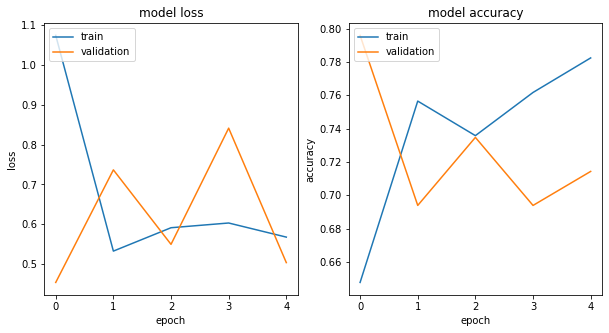

In [96]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');    
    
    

plot_curves(history, ['loss', 'accuracy'])

You can see that accuracy is at 77% for both the training and validation data, while loss bottoms out at about .477 after four epochs.

Key point: You will typically see best results with deep learning with much larger and more complex datasets. When working with a small dataset like this one, we recommend using a decision tree or random forest as a strong baseline. The goal of this tutorial is not to train an accurate model, but to demonstrate the mechanics of working with structured data, so you have code to use as a starting point when working with your own datasets in the future.

## Next steps
The best way to learn more about classifying structured data is to try it yourself. We suggest finding another dataset to work with, and training a model to classify it using code similar to the above. To improve accuracy, think carefully about which features to include in your model, and how they should be represented.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.